
$$
\begin{aligned}
(\frac{\phi^{n+1}-\phi^n}{\tau},v) + (M\nabla \mu^{n+1}, \nabla v) &= 0\ \ \ \ \forall v \in \mathbb{V} \\
(\mu^{n+1},w)-(\epsilon \nabla \phi^{n+1}, \nabla w) 
&= (\gamma ((\phi^n)^3 -\phi^n),w) \ \ \ \  \forall w \in \mathbb{V} 
\end{aligned}
$$


In [31]:
from ngsolve import *
from ngsolve.webgui import Draw
import random
import numpy as np
# Defining parameters
epsilon = 0.02
gamma = 50
M = 1e-3
maxh = 0.01 
order = 1
tau = 0.1            
T = 1
#Defining mesh and Finite element space
mesh = Mesh(unit_square.GenerateMesh(maxh=maxh))
V = H1(mesh, order=1) 
fes = V*V 

#Defining trial and test functions
phi,mu = fes.TrialFunction()  #n+1
v,w = fes.TestFunction()

#Initialising phi_0 random values between -1 and 1
phi_old = GridFunction(V)
#random_values = np.random.uniform(-1, 1, V.ndof)
random_values= np.zeros(V.ndof)
phi_old.vec.data = random_values

In [32]:
def phi_exact(t):
    return t*cos(np.pi*x)*cos(np.pi*y)

def phi_dt(t):
    return cos(np.pi*x)*cos(np.pi*y)

def phi_lap(t):
    return -2*np.pi**2*phi_exact(t)

def mu_exact():
    return cos(np.pi*x)*cos(np.pi*y)

def mu_lap():
    return -2*np.pi**2*mu_exact()

In [33]:
def FullyExplicitScheme(mesh,fes,phi,mu,v,w,phi_old,epsilon,gamma,M,tau,T):

    #Defining Bilinear form
    A = BilinearForm(fes)
    A += phi*v*dx+tau*M*grad(mu)*grad(v)*dx + mu*w*dx-epsilon*grad(phi)*grad(w)*dx
    A.Assemble()

    
    gfu = GridFunction(fes)
    gfut = GridFunction(gfu.space, multidim = 0)
    gfut.AddMultiDimComponent(gfu.vec)

    L2_error = []

    t=0
    while t<T:
        t+=tau
        rhs1 = phi_dt(t)-M*mu_lap() 
        rhs2 = mu_exact() - gamma*(phi_exact(t)**3 - phi_exact(t)) + epsilon*phi_lap(t)
            
        #Defining linear form
        f=LinearForm(fes)
        f+= tau*rhs1*v*dx+ phi_old*v*dx+gamma*(phi_old**3-phi_old)*w*dx + rhs2*w*dx
        f.Assemble()

        #Solving for phi
        gfu.vec.data = A.mat.Inverse(freedofs = fes.FreeDofs())*f.vec

        e_h = gfu.components[0]-phi_exact(t)
        norm = np.sqrt(Integrate(e_h*e_h,mesh))
        L2_error.append(norm)

        #Storing and updating phi
        gfut.AddMultiDimComponent(gfu.vec)
        phi_old.vec.data = gfu.components[0].vec


    return gfut,gfu, L2_error

In [34]:
gfut,gfu,L2_error = FullyExplicitScheme(mesh,fes,phi,mu,v,w,phi_old,epsilon,gamma,M,tau,T)
Draw(gfut.components[0], mesh, interpolate_multidim = True, animate = True)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [39]:
from ngsolve import *
from ngsolve.webgui import Draw

#Defining mesh and Finite element space
mesh = Mesh(unit_square.GenerateMesh(maxh=0.01))
V = H1(mesh, order=1) 


gfu = GridFunction(V)
gfut = GridFunction(gfu.space, multidim = 0)
gfut.AddMultiDimComponent(gfu.vec)

scene = Draw(exact,mesh)
t=0
while t<T:
    t += tau
    exact = t*cos(np.pi*x)*cos(np.pi*y)
    gfu.Set(exact)     
    gfut.AddMultiDimComponent(gfu.vec)
    #t += tau
    scene.Redraw(exact,mesh)
#Draw(gfut, mesh, interpolate_multidim = True, animate = True)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [40]:
N = np.array([0,1,2,3,4,5])
H = 0.2*2.0**(-N)
L2 = []
for h in H:
    #Defining mesh and Finite element space
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    V = H1(mesh, order=1) 
    fes = V*V 

    #Defining trial and test functions
    phi,mu = fes.TrialFunction()  #n+1
    v,w = fes.TestFunction()

    #Initialising phi_0 random values between -1 and 1
    phi_old = GridFunction(V)
    random_values= np.zeros(V.ndof)
    phi_old.vec.data = random_values

    
    gfut,gfu,L2_error = FullyExplicitScheme(mesh,fes,phi,mu,v,w,phi_old,epsilon,gamma,M,tau,T)
    L2.append(L2_error)

In [41]:
import pandas as pd
df = pd.DataFrame(L2).transpose()  
df.columns = [f"h={h:.3f}" for h in H]
df

,h=0.200,h=0.100,h=0.050,h=0.025,h=0.013,h=0.006
0,0.005497,0.004999,0.004924,0.004908,0.004905,0.004904
1,0.011387,0.010338,0.010174,0.010141,0.010133,0.010131
2,0.017718,0.015986,0.015702,0.015645,0.015632,0.015628
3,0.025244,0.022330,0.021808,0.021705,0.021681,0.021675
4,0.036622,0.030876,0.029696,0.029481,0.029431,0.029418
5,0.057429,0.044904,0.041929,0.041444,0.041329,0.041300
6,0.096808,0.069743,0.062459,0.061394,0.061135,0.061071
7,0.171328,0.115017,0.098183,0.095876,0.095293,0.095149
8,0.307960,0.201536,0.164313,0.159336,0.158002,0.157675
9,0.524919,0.366549,0.292306,0.282388,0.279529,0.278836


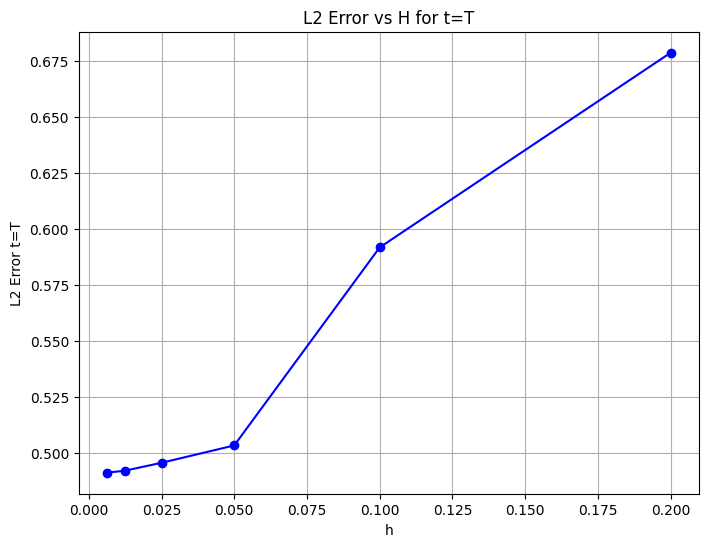

In [42]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.plot(H, df.iloc[-1], marker='o', linestyle='-', color='b')
plt.xlabel('h')
plt.ylabel('L2 Error t=T')
plt.title('L2 Error vs H for t=T')
plt.grid(True)
plt.show()
